In [ ]:
# pip install pysal

In [ ]:
# pip install geopandas

In [ ]:
# pip install contextily

In [ ]:
from pysal.lib import weights
from pysal.explore import esda
import numpy
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sn
import contextily as cx

Пространственная составляющая может влиять на регрессию двумя основными способами:


*   если *процесс, генерирующий данные носит пространственный характер*, например, заболеваемость людей определенными болезнями может зависеть от загрязненности окружающей среды;
*  если *пространственная составляющая не влияет напрямую на исходные данные моделирования, но введение ее может значительно улучшить качество модели*.

В качестве исходных данных будут использованы [данные о аренды жилья на сайте AirBnB в Сан-Диего](https://geographicdata.science/book/data/airbnb/regression_cleaning.html).

Ниже представлена структура данных

| **Переменная** 	|  **Описание** 	|
|----------------	| --------------	|
| **accommodates**	      | Количество гостей	|
|**bathrooms**	|  Количество ванных	|
| **bedrooms**	|  Количество комнат 	|
|**beds**| Количество кроватей	|
|**neighborhood**	| Район	|
| **pool**	| Наличие бассеина 	|
| **d2balboa** 	| Расстояние до парка Бальбоа	|
| **coastal** 	| Расположен ли объект в прибрежной зоне	|
|**price** 	| Цена	|
|**log_price**	| Логарифмированная цена	|
|**id**	| Порядковый номер	|
|**pg_Apartment**	| Тип объекта: квартира	|
|**pg_Condominium**	| Тип объекта: кондоминимум |
|**pg_House**	| Тип объекта: дом	|
|**pg_Other**	| Тип объекта: другой |
|**pg_Townhouse**	| Тип объекта: таунхаус	|
|**rt_Entire_home/apt**	| Сдается: квартира/дом целиком |
|**rt_Private_room**	| Сдается: комната |
|**rt_Shared_room**	| Сдается: общая комната |



In [ ]:
airbnb = gpd.read_file("https://raw.githubusercontent.com/baltti/python-spatial/main/datasets/regression_db.geojson")

airbnb.head()

,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,id,pg_Apartment,pg_Condominium,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,6,0,0,1,0,0,1,0,0,POINT (-117.12971 32.75399)
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,5570,0,1,0,0,0,1,0,0,POINT (-117.25253 32.78421)
2,2,1.0,1.0,1.0,North Hills,0,2.493893,0,99.0,4.595120,9553,1,0,0,0,0,0,1,0,POINT (-117.14121 32.75327)
3,2,1.0,1.0,1.0,Mira Mesa,0,22.293757,0,72.0,4.276666,14668,0,0,1,0,0,0,1,0,POINT (-117.15269 32.93110)
4,2,1.0,1.0,1.0,Roseville,0,6.829451,0,55.0,4.007333,38245,0,0,1,0,0,0,1,0,POINT (-117.21870 32.74202)


# Непространственная регрессия

Основная идея регрессии в том, что мы выражаем одну *зависимую переменную* через независимые переменные в виде:
<p style="text-align: center;">$P_{i} = \alpha+\sum_kX_{ik}\beta_{k}+\epsilon_{i}$</p>,
где $P_{i}$ - зависимая переменная; 

$X$ - независимые переменные; 

$\beta$ - коэффициенты регрессии; 

$\alpha$ - константа, как правило, показывающая значение зависимой переменной, если все независимые равны нулю.


In [ ]:
from pysal.model import spreg

Здесь предлагается использовать именно этот модуль, так как он позволит в дальнейшем перейти к пространственной регрессии.

In [ ]:
variable_names = ["accommodates",  # Number of people it accommodates    
                  "bathrooms",  # Number of bathrooms    
                  "bedrooms",  # Number of bedrooms    
                  "beds",  # Number of beds
                  # Below are binary variables, 1 True, 0 False
                  "rt_Private_room",  # Room type: private room
                  "rt_Shared_room",  # Room type: shared room
                  "pg_Condominium",  # Property group: condo
                  "pg_House",  # Property group: house
                  "pg_Other",  # Property group: other
                  "pg_Townhouse",  # Property group: townhouse
                  ]

Построим стандартную модель линейной регрессии зависимости цены аренды недвижимости от перечисленных выше переменных.

Обратите внимание, что как зависимая, так и независимые переменные должны быть ```array```, поэтому они предварительно извлекаются из геодатафрейма.

In [ ]:
# Fit OLS model
m1 = spreg.OLS(# Dependent variable       
               airbnb[["log_price"]].values,
               # Independent variables
               airbnb[variable_names].values,
               # Dependent variable name
               name_y="log_price",
               # Independent variable name
               name_x=variable_names)

Для анализа параметров модели используем свойство ```.summary```.

In [ ]:
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          11
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6099
R-squared           :      0.6683
Adjusted R-squared  :      0.6678
Sum squared residual:    1320.148                F-statistic           :   1229.0564
Sigma-square        :       0.216                Prob(F-statistic)     :           0
S.E. of regression  :       0.465                Log likelihood        :   -3988.895
Sigma-square ML     :       0.216                Akaike info criterion :    7999.790
S.E of regression ML:      0.4648                Schwarz criterion     :    8073.685

-----------------------------------------------------------------------------

Полученная модель линейной регрессии достаточно хорошего качества с коэффициентом детерминации 0,67.

Однако есть вероятность, что эта модель не учитывает значимые факторы, которые не являются явными, например, расположение в прибрежной пляжной зоне.

Проверим, отличается ли распределение остатков для объектов, расположенных в прибрежной зоне, и объектов, не попадающих в эту зону.
Для этого сначала введем булевую переменную ```is_coastal```, которая будет показывать, расположен объект поблизости от пляжа/берега, а потом разделим датасет по ней и построим график распределения для полученных двух наборов данных.

In [ ]:
is_coastal = airbnb.coastal.astype(bool)

# Split residuals (m1.u) between coastal and not
coastal = m1.u[is_coastal]
not_coastal = m1.u[~is_coastal]

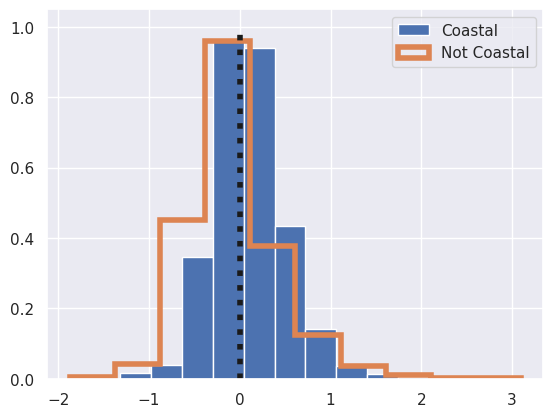

In [ ]:
# гистограмма распределения остатков для объектов, расположенных в прибрежной зоне
plt.hist(coastal, density=True, label="Coastal")

# гистограмма распределения остатков для остальных объектов
plt.hist(not_coastal,
         histtype="step",
         density=True,
         linewidth=4,
         label="Not Coastal")

# Add Line on 0
plt.vlines(0, 0, 1, linestyle=":", color="k", linewidth=4)
# Add legend
plt.legend()
# Display
plt.show()

Из графика видно, что для объектов, расположенных в прибрежной пляжной зоне ошибки немного выше.

Для сравнения двух распределений используем классический t-тест.

In [ ]:
from scipy.stats import ttest_ind

ttest_ind(coastal, not_coastal)

Ttest_indResult(statistic=array([13.98193858]), pvalue=array([9.442438e-44]))

Полученное значение t критерия и уровень его значимости говорят о том, что это действительно два значительно отличающихся друг от друга распределения.

Построим график ящик с усами для всех остатков, полученных при построение регрессионной модели, сгруппировав все наблюдения по районам.

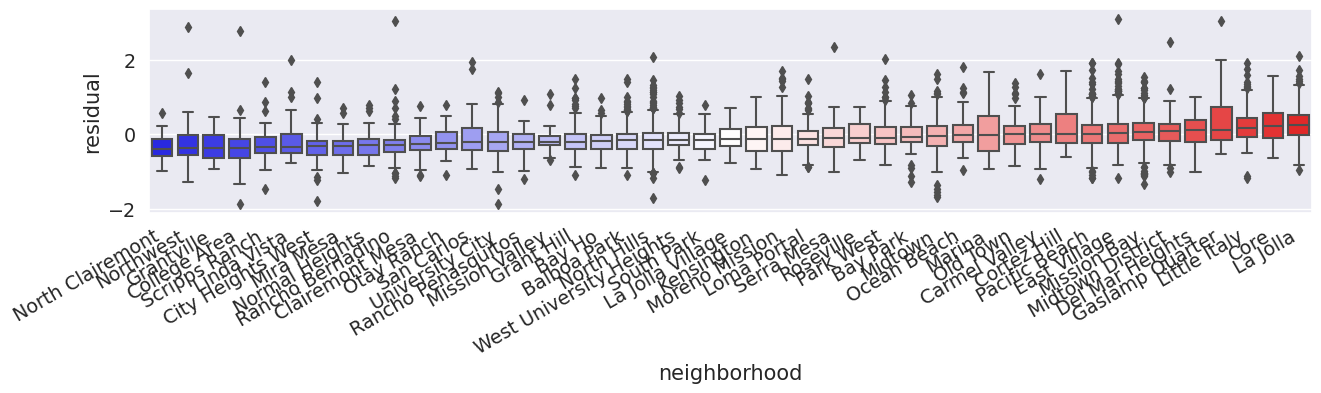

In [ ]:
# Create column with residual values from m1
airbnb["residual"] = m1.u
# Obtain the median value of residuals in each neighborhood
medians = (airbnb.groupby("neighborhood").residual.median().to_frame("hood_residual"))

# Increase fontsize
sn.set(font_scale=1.25)
# Set up figure
f = plt.figure(figsize=(15, 3))
# Grab figure's axis
ax = plt.gca()
# Generate bloxplot of values by neighborhood
# Note the data includes the median values merged on-the-fly
sn.boxplot(
    x = "neighborhood",
    y = "residual",
    ax=ax,
    data=airbnb.merge( medians, how="left", 
                      left_on="neighborhood", 
                      right_index=True).sort_values("hood_residual"),
            palette="bwr")

# Auto-format of the X labels
f.autofmt_xdate()
# Display
plt.show()

Значительных отличий между районами не наблюдается, но в некоторых из них ошибки несколько выше или ниже, чем в других, значит, скорее всего был неучтен какой-то фактор, влияющий на привлекательность района.

Вычислим пространственные веса для объектов. Эти веса будут вычислены с учетом 1 соседа (k=1), то есть будет учитываться только связь с другим ближайшим наблюдением.

In [ ]:
knn = weights.KNN.from_dataframe(airbnb, k=1)

Далее вычислим пространственный лаг для ошибок регрессионной модели и построим график Морана, чтобы выявить возможные кластеры наблюдений.

Text(0, 0.5, 'Spatial Lag of Model Residuals - $W u$')

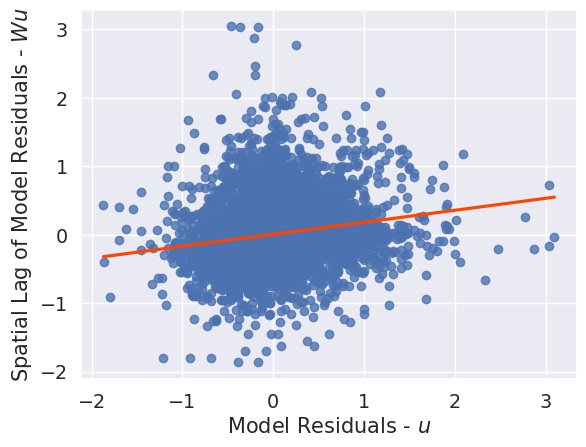

In [ ]:
lag_residual = weights.spatial_lag.lag_spatial(knn, m1.u)
ax = sn.regplot(x  = m1.u.flatten(),
                y = lag_residual.flatten(),
                line_kws=dict(color="orangered"),
                ci=None)

ax.set_xlabel("Model Residuals - $u$")
ax.set_ylabel("Spatial Lag of Model Residuals - $W u$")

Из графика видно, что полученные нами ошибки имеют тенденцию к кластеризации, а так как мы учитывали только одного ближайшего соседа при расчете пространственного лага, это значит, что при переоценке нашей моделью цены аренды конкретного объекта, также будет переоценена цена аренды соседнего объекта.

Пересчитаем пространственнные веса с учетом большего числа соседей, определим локальные коэффициенты Морана и выявим кластеры для полученных значений ошибок.

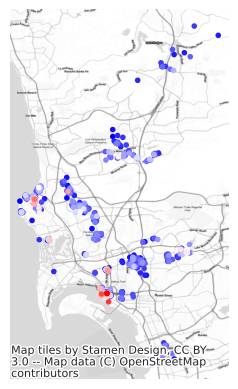

In [ ]:
## Re-weight W to 20 nearest neighbors
knn.reweight(k=20, inplace=True)

# Row standardize weights
knn.transform = "R"

# Run LISA on residuals
outliers = esda.moran.Moran_Local(m1.u, knn, permutations=9999)

# Select only LISA cluster cores
error_clusters = outliers.q % 2 == 1

# Filter out non-significant clusters
error_clusters &= outliers.p_sim <= 0.001

# Add `error_clusters` and `local_I` columns
ax = (
    airbnb.assign(
        error_clusters=error_clusters,
        local_I=outliers.Is
        # Retain error clusters only
    )
    .query(
        "error_clusters"
        # Sort by I value to largest plot on top
    )
    .sort_values(
        "local_I"
        # Plot I values
    )
    .plot("local_I", cmap="bwr", marker=".")
)

# Add basemap
cx.add_basemap(ax, crs=airbnb.crs, source=cx.providers.Stamen.TonerLite)
# Remove axes
ax.set_axis_off();

На полученной карте заметны кластеры значений ошибок, то есть в отдельных частях города стоимость аренды, полученная при построении регрессионной модели, занижается сразу для группы близко расположенных объектов, а для некоторых близко расположенных объектов эта стоимость завышается.

Получается, что у наших ошибок есть какое-то географическое распределение и за счет введения пространственной составляющей мы сможем улучшить качество модели.

# Введение пространственной составляющей

## Конструирование признаков (переменная близости)

При таком подходе в регрессионную модель просто *вводятся переменные, вычисленные на основе пространственного расположения объектов*.

В качестве примера в датасет введена переменная, показывающая близость объекта к [парку Бальбоа](https://www.tripadvisor.ru/Attraction_Review-g60750-d102782-Reviews-Balboa_Park-San_Diego_California.html), являющемуся известной туристической точкой притяжения.

Эту переменную можно назвать **пропущенной переменной с пространственным паттерном (spatially patterned omitted covariate)** - это географическая информация, позволяющая улучшить прогноз нашей модели.

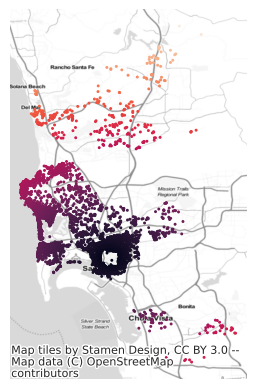

In [ ]:
ax = airbnb.plot("d2balboa", marker=".", s=5)
cx.add_basemap(ax, crs=airbnb.crs, source=cx.providers.Stamen.TonerLite)
ax.set_axis_off();

Построим новую регрессионную модель с включением нашей географической переменной.

In [ ]:
balboa_names = variable_names + ["d2balboa"]

In [ ]:
m2 = spreg.OLS(airbnb[["log_price"]].values,
               airbnb[balboa_names].values,
               name_y="log_price",
               name_x=balboa_names)

Сравним качество двух моделей.

In [ ]:
pd.DataFrame([[m1.r2, m1.ar2], [m2.r2, m2.ar2]],
             index=["M1", "M2"],
             columns=["R2", "Adj. R2"])

,R2,Adj. R2
M1,0.668345,0.667801
M2,0.668502,0.667904


Разница между двумя полученными моделями незначительна.

In [ ]:
# Set up table of regression coefficients
pd.DataFrame(
    {# Pull out regression coefficients and
     # flatten as they are returned as Nx1 array
     "Coeff.": m2.betas.flatten(),
     # Pull out and flatten standard errors
     "Std. Error": m2.std_err.flatten(),
     # Pull out P-values from t-stat object
     "P-Value": [i[1] for i in m2.t_stat],
    },
    index=m2.name_x
    )

,Coeff.,Std. Error,P-Value
CONSTANT,4.379624,0.016915,0.000000e+00
accommodates,0.083644,0.005079,1.156896e-59
bathrooms,0.190791,0.011005,9.120139e-66
bedrooms,0.150746,0.011179,7.418035e-41
beds,-0.041476,0.006939,2.394322e-09
rt_Private_room,-0.552996,0.015960,2.680270e-240
rt_Shared_room,-1.235521,0.038462,2.586867e-209
pg_Condominium,0.140459,0.022225,2.803765e-10
pg_House,-0.013302,0.014623,3.630396e-01
pg_Other,0.141176,0.022798,6.309880e-10


Проверим остатки полученной модели.

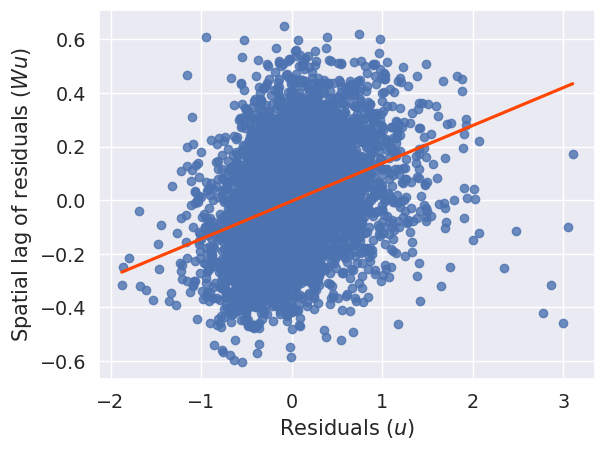

In [ ]:
lag_residual = weights.spatial_lag.lag_spatial(knn, m2.u)
ax = sn.regplot(x = m2.u.flatten(),    
                y = lag_residual.flatten(),
                line_kws=dict(color="orangered"),
                ci=None)


ax.set_xlabel("Residuals ($u$)")
ax.set_ylabel("Spatial lag of residuals ($Wu$)");

Остатки по-прежнему группируются в кластеры, значит расстояние до парка не смогло значительно улучшить качество модели.

Следует отметить, что в данном случае коэффициент при этой переменной положительный, значит, цена аренды и привлекательность возрастает с удалением от парка.

### Пространственная неоднородность

**Пространственная неоднородность** значит, что *отдельные части модели могут меняться варьироваться от местоположения*, изменяться в различных местах.

Например, изменение независимого коэффициента может отражать, что в разных областях разное базовое воздействие исследуемого процесса, а изменение коэффициентов при переменных может значить, что есть какой-то опосредованный географический фактор, влияющий на взаимодействие между зависимой и независимыми переменными (например, какое-нибудь ограничение на использование земли в определенных частях города).

#### Простанственные фиксированные эффекты (spatial fixed effects)

Влияние пространственных фиксированных эффектов, как правило, учитывается через свободный член регрессионной модели $\alpha$.

При включении в регрессионную модель *возможно, что упускаются из вида факторы, влияющие на зависимую переменную, однако, можно предположить, что они систематически меняются в пространстве.*

При построении модели можно учесть эти неявные переменные, введя бинарные переменные на основе пространственного правила (то есть присваивать 1 объектам, находящемся в определенном районе, а остальным - 0).

Уравнение регрессии меняется при этом на:

<p style="text-align: center;">$P_{i} = \alpha_{r} + \sum_kX_{ik}\beta_{k} + \epsilon_{i}$, <p\>

где свободный член $\alpha_{r}$ может меняться в зависимости от района.

Для построения новой модели с учетом пространственных фиксированных эффектов воспользуемся ```statsmodels```. Использование этого пакета позволяет задать сразу формулу нашего уравнения с помощью оператора ~, показывающего функциональную зависимость.


In [ ]:
import statsmodels.formula.api as sm

In [ ]:
f = ("log_price ~ "
    + " + ".join(variable_names)
    + " + neighborhood - 1")

print(f)

log_price ~ accommodates + bathrooms + bedrooms + beds + rt_Private_room + rt_Shared_room + pg_Condominium + pg_House + pg_Other + pg_Townhouse + neighborhood - 1


In [ ]:
m3 = sm.ols(f, data=airbnb).fit()

Для отображения параметров регрессии можно воспользоваться методом ```summary2()```, однако в нашем случае мы ограничимся только извлечением пространственных эффектов из модели.

In [ ]:
# Store variable names for all the spatial fixed effects
sfe_names = [i for i in m3.params.index if "neighborhood[" in i]
# Create table
pd.DataFrame(
    {"Coef.": m3.params[sfe_names], 
     "Std. Error": m3.bse[sfe_names],
     "P-Value": m3.pvalues[sfe_names],
    }
)

,Coef.,Std. Error,P-Value
neighborhood[Balboa Park],4.280766,0.033292,0.0
neighborhood[Bay Ho],4.198251,0.076878,0.0
neighborhood[Bay Park],4.329223,0.050987,0.0
neighborhood[Carmel Valley],4.389261,0.056553,0.0
neighborhood[City Heights West],4.053518,0.058378,0.0
neighborhood[Clairemont Mesa],4.095259,0.047699,0.0
neighborhood[College Area],4.033697,0.058258,0.0
neighborhood[Core],4.726186,0.052643,0.0
neighborhood[Cortez Hill],4.608090,0.051526,0.0
neighborhood[Del Mar Heights],4.496910,0.054337,0.0


Фактически в этом случае район используется как категориальная переменная, на основе которой конструируется бинарная.

С экономической точки зрения при построении этой модели мы не использовали все стоимости аренды как равные, а рассматривали их только в рамках одного городского района.

> Введение фиксированных пространственных эффектов позволяет проконтролировать скрытые эффекты, которые распределены географически, то есть мы отчасти изолируем эффекты переменных.

Для анализа пространственных эффектов нужно немного обработать данные дополнительно.

В первую очередь извлечем эффекты, ассоциированные с отдельными районами.

In [ ]:
neighborhood_effects = m3.params.filter(like="neighborhood")
neighborhood_effects.head()

neighborhood[Balboa Park]          4.280766
neighborhood[Bay Ho]               4.198251
neighborhood[Bay Park]             4.329223
neighborhood[Carmel Valley]        4.389261
neighborhood[City Heights West]    4.053518
dtype: float64

Далее извлечем из результата только название района, убрав ненужные нам символы.

In [ ]:
# Create a sequence with the variable names without
# `neighborhood[` and `]`
stripped = neighborhood_effects.index.str.strip(
    "neighborhood["
).str.strip("]")
# Reindex the neighborhood_effects Series on clean names
neighborhood_effects.index = stripped
# Convert Series to DataFrame
neighborhood_effects = neighborhood_effects.to_frame("fixed_effect")
# Print top of table
neighborhood_effects.head()

,fixed_effect
Balboa Park,4.280766
Bay Ho,4.198251
Bay Park,4.329223
Carmel Valley,4.389261
City Heights West,4.053518


Следующим шагом загрузим границы городских районов и объединим их с нашими полученными значениями эффектов, а потом отобразим на карте.

In [ ]:
neighborhoods = gpd.read_file("http://data.insideairbnb.com/united-states/ca/san-diego/2023-03-24/visualisations/neighbourhoods.geojson")

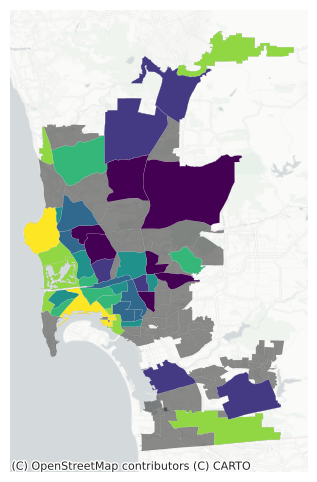

In [ ]:
# Plot base layer with all neighborhoods in grey
ax = neighborhoods.plot(
    color="k", linewidth=0, alpha=0.5, figsize=(12, 6)
)
# Merge SFE estimates (note not every polygon
# receives an estimate since not every polygon
# contains Airbnb properties)
neighborhoods.merge(
    neighborhood_effects,
    how="left",
    left_on="neighbourhood",
    right_index=True
    # Drop polygons without a SFE estimate
).dropna(
    subset=["fixed_effect"]
    # Plot quantile choropleth
).plot(
    "fixed_effect",  # Variable to display
    scheme="quantiles",  # Choropleth scheme
    k=7,  # No. of classes in the choropleth
    linewidth=0.1,  # Polygon border width
    cmap="viridis",  # Color scheme
    ax=ax,  # Axis to draw on
)
# Add basemap
cx.add_basemap(
    ax,
    crs=neighborhoods.crs,
    source=cx.providers.CartoDB.PositronNoLabels,
)
# Remove axis
ax.set_axis_off()
# Display
plt.show()

#### Пространственные режимы (spatial regimes)

> При использовании **фиксированных эффектов** мы предполагаем, что *зависимая переменная изменяется не однородно в пространстве, а с учетом какого-то паттерна*. При этом *изменяется только свободный член уравнения модели, а все остальные коэффициенты остаются неизменными на всей территории*.

При использовании **пространственных режимов** будет *меняться не только свободный член уравнения, но и все остальные коэффициенты*, то есть мы переходим к уравнению:

<p style="text-align: center;">$P_{i} = \alpha_{r} + \sum_kX_{ik}\beta_{k-r} + \epsilon_{i}$,<p\>

где меняется не только константа/свободный член $\alpha_{r}$, но и остальные параметры модели $\beta_{k-r}$.

Для иллюстрации этого подхода воспользуемся введенной дополнительной переменной, в которой указано расположен ли объект в прибрежной зоне или нет.

In [ ]:
# Pysal spatial regimes implementation
m4 = spreg.OLS_Regimes(# Dependent variable
                       airbnb[["log_price"]].values,
                       # Independent variables
                       airbnb[variable_names].values,
                       # Variable specifying neighborhood membership
                       airbnb["coastal"].tolist(),
                       # Allow the constant term to vary by group/regime
                       constant_regi="many",
                       # Allow separate sigma coefficients to be estimated
                       # by regime (False so a single sigma)
                       regime_err_sep=False,
                       # Dependent variable name
                       name_y="log_price",
                       # Independent variables names
                       name_x=variable_names)

In [ ]:
# Results table
res = pd.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m4.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m4.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m4.t_stat],
    },
    index=m4.name_x,
)
# Coastal regime
## Extract variables for the coastal regime
coastal = [i for i in res.index if "1_" in i]
## Subset results to coastal and remove the 1_ underscore
coastal = res.loc[coastal, :].rename(lambda i: i.replace("1_", ""))
## Build multi-index column names
coastal.columns = pd.MultiIndex.from_product(
    [["Coastal"], coastal.columns]
)
# Non-coastal model
## Extract variables for the non-coastal regime
ncoastal = [i for i in res.index if "0_" in i]
## Subset results to non-coastal and remove the 0_ underscore
ncoastal = res.loc[ncoastal, :].rename(lambda i: i.replace("0_", ""))
## Build multi-index column names
ncoastal.columns = pd.MultiIndex.from_product(
    [["Non-coastal"], ncoastal.columns]
)
# Concat both models
pd.concat([coastal, ncoastal], axis=1)

Coastal                          Non-coastal             \
                   Coeff. Std. Error       P-Value      Coeff. Std. Error   
CONSTANT         4.479904   0.025094  0.000000e+00    4.407242   0.021516   
accommodates     0.048464   0.007881  8.253761e-10    0.090186   0.006474   
bathrooms        0.247478   0.016566  1.381278e-49    0.143376   0.014268   
bedrooms         0.189740   0.017923  5.783965e-26    0.112963   0.013827   
beds            -0.050608   0.010743  2.522348e-06   -0.026272   0.008838   
rt_Private_room -0.558628   0.028312  4.723759e-84   -0.529334   0.018918   
rt_Shared_room  -1.052854   0.084174  1.836512e-35   -1.224459   0.042597   
pg_Condominium   0.204447   0.033943  1.810152e-09    0.105307   0.028131   
pg_House         0.075353   0.023378  1.274269e-03   -0.045447   0.017957   
pg_Other         0.295485   0.038645  2.394157e-14    0.060753   0.027637   
pg_Townhouse    -0.073508   0.049367  1.365396e-01   -0.010397   0.045673   

                                
                       P-Value  
CONSTANT          0.000000e+00  
accommodates      1.893020e-43  
bathrooms         1.418804e-23  
bedrooms          3.731742e-16  
beds              2.964354e-03  
rt_Private_room  3.546091e-162  
rt_Shared_room   1.657163e-170  
pg_Condominium    1.831822e-04  
pg_House          1.140318e-02  
pg_Other          2.796727e-02  
pg_Townhouse      8.199294e-01

Так как значения параметров модели отличаются в пространстве, то может возникнут вопрос: отличаются ли оценки этих переменных статистически?

Для проверки этого используется **тест Чоу (Chow test)**, который позволяет оценить отличаются ли параметры уравнения регрессии после разделения выборки на части. (https://wiki.loginom.ru/articles/chow-test.html)

In [ ]:
m4.chow.joint

(328.86902143027976, 7.113548767370635e-64)

Первое значение здесь показывает значение статистики тест Чоу, а второе - p-значение.

В нашем примере две части выборки/два использованных режима отличаются друг от друга и эта разница является статистически значимой.

Проверим, отличаются ли друг от друга коэффициенты уравнения.

In [ ]:
pd.DataFrame(
    # Chow results by variable
    m4.chow.regi,
    # Name of variables
    index=m4.name_x_r,
    # Column names
    columns=["Statistic", "P-value"],
)

,Statistic,P-value
CONSTANT,4.832180,2.793329e-02
accommodates,16.735685,4.296522e-05
bathrooms,22.671471,1.922004e-06
bedrooms,11.503786,6.945459e-04
beds,3.060313,8.022620e-02
rt_Private_room,0.740097,3.896298e-01
rt_Shared_room,3.308838,6.890820e-02
pg_Condominium,5.057283,2.452265e-02
pg_House,16.792503,4.169771e-05
pg_Other,24.409876,7.786847e-07


### Пространственная зависимость

> **Пространственная неоднородность** - это влияние явлений, которые непосредственно и явно связаны в положением в пространстве, что приводит к кластеризации и пространственной вариации. В некоторых случаях мы рассматриваем еще и эффект пространственной конфигурации. Такие эффекты значительно отличаются от пространственной неоднородности и появляются благодаря влиянию окружения, то есть это не непосредственно расположение объектов в пространстве, а связь с другими объектами датасета и их пространственное положение относительно друг друга. 

Явление, при котором значения наблюдений связаны между собой через расстояние, называется **пространственной зависимостью**.

Есть несколько способов учитывать пространственную зависимость, общим для них будет являться то, как пространство реализовано, - *матрица пространственных весов*. Эта матрица может быть включена в регрессионную модель несколькими различными способами, которые будут рассмотрены ниже.

#### Внешние эффекты: SLX модель

Продолжим анализировать датасет со стоимостью аренды квартир с помощью сервиса AirBnB в Сан-Диего. До этого мы выдвигали гипотезы только о том, что на стоимость аренды будет влиять расположение объекта, однако, возможно, стоит учесть еще и то, что людей будут привлекать определенные районы и определенное окружение, конкретные тпы застройки окрестностей.

Самый простой способ привнести в регрессионную модель пространственную зависимость - это учитывать не только саму переменную, но и ее пространственный лаг.

В рассматриваемом примере мы введем фиктивную переменную типа дома и включим в регрессионную модель пространственный лаг для каждого типа дома:

<p style="text-align: center;">$P_{i} = \alpha + \sum_{k=1}^pX_{ij}\beta_{i} + \sum_{k=1}^p\left(\sum_{j=1}^Nw_{ij}x_{jk}\right)\gamma_{k} + \epsilon_{i}$,<p\>

где $\sum_{j=1}^Nw_{ij}x_{jk}$ это пространственный лаг независимой переменной.

С использованием матрицы весов, формула может быть преобразована в матричный вид:

<p style="text-align: center;">$P_{i} = \alpha + X\beta + WX\gamma + \epsilon$.<p\>

Таким образом, мы фокусируемся на двух основных коэффициентах модели: $\beta$ и $\gamma$. 

$\beta$ показывает на сколько измениться зависимая переменная при изменении независимой переменной $X_{ik}$ на 1.

Коэффициент $\gamma$ показывает же непрямую связь между $X_{i}$ и зависимой переменной. Самая простая интерпретация этого эффекта состоит в том, что мы таким образом *учитываем связь цены аренды при изменении окружения объекта*. Фактически изменение цены аренды повлечет за собой "перелив" в окрестностях объекта, так как он вызовет изменение пространственного лага.

Конкретная величина изменения пространственного лага будет зависеть от структуры матрицы пространственных весов. Так, например, для объекта с большим числом соседей изменение значения у одного из них повлечет небольшое изменение в пространственном лаге, так как одновременно на объект будут влиять все соседи. Тогда как для объекта с одним соседом изменения повлекут точно такие же изменения в пространственном лаге, так как на него не влияют никакие другие объекты.

В первую очереди создадим список всех переменных, отвечающих за тип дома в датасете, а потом рассчитаем пространственный лаг для них.

In [ ]:
# Select only columns in `db` containing the keyword `pg_`
wx = (
    airbnb.filter(
        like="pg_"
        # Compute the spatial lag of each of those variables
    )
    .apply(
        lambda y: weights.spatial_lag.lag_spatial(knn, y)
        # Rename the spatial lag, adding w_ to the original name
    )
    .rename(
        columns=lambda c: "w_"
        + c
        # Remove the lag of the binary variable for apartments
    )
    .drop("w_pg_Apartment", axis=1)
)

Далее построим линейную модель регресии, включив в нее пространственные лаги переменных.

In [ ]:
# Merge original variables with the spatial lags in `wx`
slx_exog = airbnb[variable_names].join(wx)
# Fit linear model with `spreg`
m5 = spreg.OLS(# Dependent variable
               airbnb[["log_price"]].values,
               # Independent variables 
               slx_exog.values,
               # Dependent variable name
               name_y="l_price",
               # Independent variables names
               name_x=slx_exog.columns.tolist())

Выделим только коэффициенты тех переменных, для которых был рассчитан пространственный лаг.

In [ ]:
# Collect names of variables of interest
vars_of_interest = (
    airbnb[variable_names].filter(like="pg_").join(wx).columns
)
# Build full table of regression coefficients
pd.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m5.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m5.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m5.t_stat],
    },
    index=m5.name_x
    # Subset for variables of interest only and round to
    # four decimals
).reindex(vars_of_interest).round(4)

,Coeff.,Std. Error,P-Value
pg_Condominium,0.1063,0.0222,0.0000
pg_House,0.0328,0.0157,0.0368
pg_Other,0.0862,0.0240,0.0003
pg_Townhouse,-0.0277,0.0338,0.4130
w_pg_Condominium,0.5928,0.0690,0.0000
w_pg_House,-0.0774,0.0319,0.0152
w_pg_Other,0.4851,0.0551,0.0000
w_pg_Townhouse,-0.2724,0.1223,0.0260


Для всех перечисленных выше переменных пространственный лаг включен как ```w_pg_xxxx```.

В рассматриваемом случае все коэффициенты за исключением одного являются статистически значимыми.

Рассмотрим прямые и непрямые эффекты переменных. Прямые эффекты подразумевают большую или меньшую стоимость аренды для различных типов недвижимости. Пространственный лаг в данном случае отвечает за непрямое влияние на аренду. Так как в нашем случае используются фиктивные переменные, то пространственный лаг показывает процент домов такого же типа в окружении конкретного объекта, то есть изменение его на 1 повлечет за собой 100% изменения в окружении объекта.

In [ ]:
# Print first three predicted values
m5.predy[:3]

array([[5.43610121],
       [5.38596868],
       [4.25377454]])

Для проверки влияния изменения переменной и изменения окружения переведем один из объектов в другую категорию недвижимости (кондоминиум).

In [ ]:
# Print values for third observation for columns spanning
# from `pg_Apartment` to `pg_Townhouse`
airbnb.loc[2, "pg_Apartment":"pg_Townhouse"]

pg_Apartment      1
pg_Condominium    0
pg_House          0
pg_Other          0
pg_Townhouse      0
Name: 2, dtype: object

In [ ]:
# Make copy of the dataset
airbnb_scenario = airbnb.copy()
# Make Apartment 0 and condo 1 for third observation
airbnb_scenario.loc[2, ["pg_Apartment", "pg_Condominium"]] = [0, 1]

In [ ]:
airbnb_scenario.loc[2, "pg_Apartment":"pg_Townhouse"]

pg_Apartment      0
pg_Condominium    1
pg_House          0
pg_Other          0
pg_Townhouse      0
Name: 2, dtype: object

Пересчитаем пространственный лаг.

In [ ]:
# Select only columns containing the keyword `pg_`
wx_scenario = (
    airbnb_scenario.filter(
        like="pg"
        # Compute the spatial lag of each of those variables
    )
    .apply(
        lambda y: weights.spatial_lag.lag_spatial(knn, y)
        # Rename the spatial lag, adding w_ to the original name
    )
    .rename(
        columns=lambda c: "w_"
        + c
        # Remove the lag of the binary variable for apartments
    )
    .drop("w_pg_Apartment", axis=1)
)

Построим новую матрицу переменных $X$.

In [ ]:
slx_exog_scenario = airbnb_scenario[variable_names].join(wx_scenario)

Далее рассчитаем новые значения модели, с учетом только что созданных искусственных переменных.

In [ ]:
# Compute new set of predicted values
y_pred_scenario = m5.betas[0] + slx_exog_scenario @ m5.betas[1:]

Единственная разница между исходной моделью ```m5``` и новой в том, что мы изменили один объект, то есть эти изменения должны затронуть только соседние к нему объекты, все остальные должны остаться неизменными.

Для того, чтобы выявить разницу, определим, кто же является соседями модифицированного нами объекта, на основе матрицы весов.

In [ ]:
print(knn.neighbors[2])

[772, 2212, 139, 4653, 2786, 1218, 138, 808, 1480, 4241, 1631, 3617, 2612, 1162, 135, 23, 5528, 3591, 407, 6088]


Проверим, насколько изменились значения у этих объектов.

In [ ]:
# Difference between original and new predicted values
(
    y_pred_scenario
    - m5.predy
    # Subset to site `2` and its neighbors
).loc[[2] + knn.neighbors[2]]

,0
2,0.106349
772,0.029642
2212,0.029642
139,0.029642
4653,0.029642
2786,0.029642
1218,0.029642
138,0.029642
808,0.029642
1480,0.029642


В первой строке преставлен прямой эффект наших изменений, который равен коэффииценту при переменной ```pg_Condominium``` в исходной модели ```m5```.

Для всех остальных объектов непрямое влияние на остальные объекты можно выразить как коэффициент переменной ```w_pg_Condominium``` (представляющей пространственный лаг), деленный на вес измененным объектом и его соседними объектами. В этом случае изменения для всех соседних объектов одинаковы, так как они имеют одинаковый вес, в случае разных значений весов, изменения были бы пропорциональны им.

#### Пространственная ошибка (spatial error)

При использовании пространственной ошибки, в уравнение линейной регрессии в ошибку включается пространственный лаг:

<p style="text-align: center;">$P_{i} = \alpha + \sum_k\beta_{k}X_{ki}+ u_{i}$,<p\>

<p style="text-align: center;">$u_{i} = \lambda u_{lag-i} + \epsilon_{i}$,<p \>

где $u_{lag-i} = \sum_{j}w_{i,j}u_{j}$.

> Это *противоречит стандартному понятию ошибки модели линейной регрессии*, что приводит к необходимости использования альтернативных методов оценки модели.

In [ ]:
# Fit spatial error model with `spreg`
# (GMM estimation allowing for heteroskedasticity)
m6 = spreg.GM_Error_Het(# Dependent variable
                        airbnb[["log_price"]].values,
                        # Independent variables
                        airbnb[variable_names].values,
                        # Spatial weights matrix
                        w=knn,
                        # Dependent variable name
                        name_y="log_price",
                        # Independent variables names
                        name_x=variable_names)

Полученная модель и ее параметры могут быть интерпретированы аналогично тому, что было рассмотрено выше, главное, что отличает ее от других моделей - это параметр $\lambda$.

In [ ]:
# Build full table of regression coefficients
pd.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m6.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m6.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m6.z_stat],
    },
    index=m6.name_x
    # Subset for lambda parameter and round to
    # four decimals
).reindex(["lambda"]).round(4)

,Coeff.,Std. Error,P-Value
lambda,0.6449,0.0187,0.0


#### Пространственный лаг

Модель с пространственным лагом включает в себя пространственный лаг в качестве зависимой переменной, что можно привести в виде формулы:

<p style="text-align: center;">$P_{i} = \alpha + \rho P_{lag-i} + \sum_k\beta_{k}X_{ki} + \epsilon_{i}$.<p\>

> Такая модель *противоречит допущению об экзогенности*, то есть в этом уравнении *изменение зависимой переменной повлечет за собой изменений независимой*. При выполнении этого допущения связь работает только в одну сторону: независимые переменные влияют на зависимую.

В нашем случае это допущение нарушается, так как $P_{i}$ существует по обе стороны знака равенства. 

Для того, чтобы преодолеть это нарушение, могут использоваться различные методы, например, мы используем двухэтапный метод наименьших квадратов, реализованный в библиотеке ```pysal```.

In [ ]:
# Fit spatial lag model with `spreg`
# (GMM estimation)
m7 = spreg.GM_Lag(# Dependent variable
                  airbnb[["log_price"]].values,
                  # Independent variables
                  airbnb[variable_names].values,
                  # Spatial weights matrix
                  w=knn,
                  # Dependent variable name
                  name_y="log_price",
                  # Independent variables names
                  name_x=variable_names)

Ознакомимся с параметрами полученной модели.

In [ ]:
# Build full table of regression coefficients
pd.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m7.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m7.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m7.z_stat],
    },
    index=m7.name_z
    # Round to four decimals
).round(4)

,Coeff.,Std. Error,P-Value
CONSTANT,2.7440,0.0727,0.0000
accommodates,0.0698,0.0048,0.0000
bathrooms,0.1627,0.0104,0.0000
bedrooms,0.1604,0.0105,0.0000
beds,-0.0365,0.0065,0.0000
rt_Private_room,-0.4981,0.0151,0.0000
rt_Shared_room,-1.1157,0.0366,0.0000
pg_Condominium,0.1073,0.0209,0.0000
pg_House,-0.0004,0.0137,0.9766
pg_Other,0.1208,0.0215,0.0000


Полученные результаты нужно интерпретировать очень внимательно.

Так в этой модели ```W_log_price``` применяется ко всем наблюдениям и меняет влияние всех коэффициентов $\beta$. Поэтому для определения прямого и непрямого влияния рекомендуется анализировать различные сценарии изменения зависимой переменной.